# Model Token Costs

This notebook uses `model_token_usage.csv` as the source of truth for token accounting.

- The default table groups by `Strategist` and `Model Name`, so briefed configs can show separate strategist-model and briefer-model cost rows
- Change `GROUP_BY` to `'model_name'` to collapse across strategists and summarize by actual telemetry model
- `Avg. Output` is `reasoning_tokens + output_tokens`
- Games with missing token data are excluded from the averages and reported in `N/A Games`
- `Total Cost` is computed from the actual telemetry model rows, so briefed configs are priced correctly
- The final cell visualizes `focus_briefer_count` per game for briefed configs


In [79]:
from pathlib import Path
import sys

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from IPython.display import display

repo_root = Path.cwd()
if not (repo_root / 'model_token_usage.csv').exists():
    repo_root = repo_root.parent

if not (repo_root / 'model_token_usage.csv').exists():
    raise FileNotFoundError('Could not find model_token_usage.csv from the current notebook working directory.')

if str(repo_root) not in sys.path:
    sys.path.append(str(repo_root))

from plot_utilities import CONDITION_PLAYER_MAPPING

sns.set_theme(style='whitegrid')

DATA_PATH = repo_root / 'model_token_usage.csv'
GROUP_BY = 'strategist_model'  # Change to 'model_name' to collapse across strategists


def resolve_expected_player_type(experiment, player_id, fallback_player_type):
    player_types = CONDITION_PLAYER_MAPPING.get(experiment)
    if player_types is None:
        return fallback_player_type

    try:
        player_id = int(player_id)
    except (TypeError, ValueError):
        return fallback_player_type

    if 0 <= player_id < len(player_types):
        return player_types[player_id]

    return fallback_player_type


In [80]:
# Fill these placeholder prices with your real per-1M-token pricing.
# Simple and Briefed variants share the same base-model price.
PRICING_PER_MILLION = {
    'Deepseek-3.2': {'input_per_million': 0.26, 'output_per_million': 0.38},
    'GLM-4.7': {'input_per_million': 0.39, 'output_per_million': 1.75},
    'GPT-OSS-120B': {'input_per_million': 0.039, 'output_per_million': 0.19},
    'Kimi-K2.5': {'input_per_million': 0.45, 'output_per_million': 2.2},
    'Minimax-M2.5': {'input_per_million': 0.2, 'output_per_million': 1.17},
    'Qwen-3.5': {'input_per_million': 0.39, 'output_per_million': 2.34},
    'Sonnet-4.5': {'input_per_million': 3.0, 'output_per_million': 15.0},
}

PRICING_PER_MILLION


{'Deepseek-3.2': {'input_per_million': 0.26, 'output_per_million': 0.38},
 'GLM-4.7': {'input_per_million': 0.39, 'output_per_million': 1.75},
 'GPT-OSS-120B': {'input_per_million': 0.039, 'output_per_million': 0.19},
 'Kimi-K2.5': {'input_per_million': 0.45, 'output_per_million': 2.2},
 'Minimax-M2.5': {'input_per_million': 0.2, 'output_per_million': 1.17},
 'Qwen-3.5': {'input_per_million': 0.39, 'output_per_million': 2.34},
 'Sonnet-4.5': {'input_per_million': 3.0, 'output_per_million': 15.0}}

In [81]:
telemetry_df = pd.read_csv(DATA_PATH)
telemetry_df['player_type'] = telemetry_df['player_type'].fillna('N/A')
telemetry_df['csv_player_type'] = telemetry_df['player_type']
telemetry_df['expected_player_type'] = [
    resolve_expected_player_type(experiment, player_id, fallback_player_type)
    for experiment, player_id, fallback_player_type in zip(
        telemetry_df['experiment'],
        telemetry_df['player_id'],
        telemetry_df['csv_player_type'],
    )
]
telemetry_df['player_type'] = telemetry_df['expected_player_type']
telemetry_df = telemetry_df[~telemetry_df['player_type'].isin(['Vanilla', 'Null', 'N/A'])].copy()

numeric_cols = [
    'input_tokens',
    'reasoning_tokens',
    'output_tokens',
    'total_tokens',
    'tool_count',
    'focus_briefer_count',
    'valid_turn_count',
]

for col in numeric_cols:
    telemetry_df[col] = pd.to_numeric(telemetry_df[col], errors='coerce')

telemetry_df['base_model'] = telemetry_df['model_name']
telemetry_df['combined_output_tokens'] = telemetry_df['reasoning_tokens'] + telemetry_df['output_tokens']
telemetry_df['tokens_missing'] = telemetry_df[['input_tokens', 'reasoning_tokens', 'output_tokens']].isna().any(axis=1)

telemetry_df[[
    'game_id',
    'player_type',
    'model_name',
    'base_model',
    'input_tokens',
    'combined_output_tokens',
    'tool_count',
    'focus_briefer_count',
    'tokens_missing',
]].head()


game_id        player_type    model_name  \
0  085cfce3-75ee-4459-b7b0-c49c9a27f651   Kimi-K2.5-Simple     Kimi-K2.5   
1  085cfce3-75ee-4459-b7b0-c49c9a27f651  Kimi-K2.5-Briefed  GPT-OSS-120B   
2  085cfce3-75ee-4459-b7b0-c49c9a27f651  Kimi-K2.5-Briefed     Kimi-K2.5   
3  085cfce3-75ee-4459-b7b0-c49c9a27f651     GLM-4.7-Simple       GLM-4.7   
4  085cfce3-75ee-4459-b7b0-c49c9a27f651    GLM-4.7-Briefed       GLM-4.7   

     base_model  input_tokens  combined_output_tokens  tool_count  \
0     Kimi-K2.5      13693349                 1442497        1489   
1  GPT-OSS-120B      20391531                 2498783           0   
2     Kimi-K2.5       8699972                 1871215        2410   
3       GLM-4.7      14755779                 1070339        1213   
4       GLM-4.7       8195436                 1200784        1650   

   focus_briefer_count  tokens_missing  
0                    0           False  
1                    0           False  
2                  792           False  
3                    0           False  
4                  281           False

In [82]:
def complete_group_sum(series):
    return series.sum(min_count=len(series))


def format_number(value):
    if pd.isna(value):
        return 'N/A'
    return f'{value:,.0f}'


def format_currency(value):
    if pd.isna(value):
        return 'N/A'
    return f'${value:,.2f}'


def format_cost_per_unit(model_name, pricing_per_million):
    input_price = pricing_per_million.get(model_name, {}).get('input_per_million')
    output_price = pricing_per_million.get(model_name, {}).get('output_per_million')
    if input_price is None or output_price is None:
        return 'Missing pricing'
    return f"${input_price:,.2f} in / ${output_price:,.2f} out per 1M"


def build_token_cost_table(df, group_by='strategist_model', pricing_per_million=None):
    if group_by not in {'strategist_model', 'model_name'}:
        raise ValueError("group_by must be 'strategist_model' or 'model_name'")

    pricing_per_million = pricing_per_million or {}
    working_df = df.copy()

    working_df['input_price_per_million'] = working_df['model_name'].map(
        lambda model: pricing_per_million.get(model, {}).get('input_per_million')
    )
    working_df['output_price_per_million'] = working_df['model_name'].map(
        lambda model: pricing_per_million.get(model, {}).get('output_per_million')
    )
    working_df['row_cost'] = (
        working_df['input_tokens'] / 1_000_000 * working_df['input_price_per_million']
        + working_df['combined_output_tokens'] / 1_000_000 * working_df['output_price_per_million']
    )

    grouping_cols = ['model_name'] if group_by == 'model_name' else ['player_type', 'model_name']

    per_game = (
        working_df.groupby(['game_id', *grouping_cols], as_index=False)
        .agg(
            input_tokens=('input_tokens', complete_group_sum),
            combined_output_tokens=('combined_output_tokens', complete_group_sum),
            total_cost=('row_cost', complete_group_sum),
        )
    )

    per_game['token_data_available'] = per_game[['input_tokens', 'combined_output_tokens', 'total_cost']].notna().all(axis=1)
    valid_per_game = per_game[per_game['token_data_available']].copy()

    summary = (
        per_game.groupby(grouping_cols, as_index=False)
        .agg(
            Games=('game_id', 'nunique'),
            **{'N/A Games': ('token_data_available', lambda s: (~s).sum())},
        )
    )

    averages = (
        valid_per_game.groupby(grouping_cols, as_index=False)
        .agg(
            avg_input=('input_tokens', 'mean'),
            avg_output=('combined_output_tokens', 'mean'),
            total_cost=('total_cost', 'sum'),
        )
    )

    summary = summary.merge(averages, on=grouping_cols, how='left')

    if group_by == 'strategist_model':
        summary['Strategist'] = summary['player_type']
    else:
        summary['Strategist'] = 'All Strategists'

    summary['Model Name'] = summary['model_name']
    summary['Cost Per Unit'] = summary['Model Name'].map(
        lambda model: format_cost_per_unit(model, pricing_per_million)
    )
    summary = summary[[
        'Strategist',
        'Model Name',
        'Games',
        'N/A Games',
        'avg_input',
        'avg_output',
        'Cost Per Unit',
        'total_cost',
    ]].rename(columns={
        'avg_input': 'Avg. Input',
        'avg_output': 'Avg. Output',
        'total_cost': 'Total Cost',
    })

    return summary.sort_values(['Strategist', 'Model Name']).reset_index(drop=True)


summary_numeric = build_token_cost_table(
    telemetry_df,
    group_by=GROUP_BY,
    pricing_per_million=PRICING_PER_MILLION,
)

summary_display = summary_numeric.copy()
summary_display['Games'] = summary_display['Games'].map(format_number)
summary_display['N/A Games'] = summary_display['N/A Games'].map(format_number)
summary_display['Avg. Input'] = summary_display['Avg. Input'].map(format_number)
summary_display['Avg. Output'] = summary_display['Avg. Output'].map(format_number)
summary_display['Total Cost'] = summary_display['Total Cost'].map(format_currency)

display(summary_display)
print(summary_display.to_markdown(index=False))

overall_total_cost = summary_numeric['Total Cost'].sum(min_count=1)
overall_total_cost_display = pd.DataFrame([
    {'Metric': 'Overall Total Cost', 'Value': format_currency(overall_total_cost)}
])
display(overall_total_cost_display)
print(f"Overall Total Cost: {format_currency(overall_total_cost)}")


Strategist    Model Name Games N/A Games  Avg. Input  \
0   Deepseek-3.2-Briefed  Deepseek-3.2   113         0   7,109,358   
1   Deepseek-3.2-Briefed  GPT-OSS-120B   113         0  15,162,780   
2    Deepseek-3.2-Simple  Deepseek-3.2   113         0  14,349,173   
3        GLM-4.7-Briefed       GLM-4.7   178         0   7,599,886   
4        GLM-4.7-Briefed  GPT-OSS-120B   178         0  15,737,605   
5         GLM-4.7-Simple       GLM-4.7   179         0  13,725,978   
6   GPT-OSS-120B-Briefed  GPT-OSS-120B   145         0  24,887,643   
7    GPT-OSS-120B-Simple  GPT-OSS-120B   145         0  13,774,302   
8      Kimi-K2.5-Briefed  GPT-OSS-120B   167         0  16,934,443   
9      Kimi-K2.5-Briefed     Kimi-K2.5   167         0   7,481,619   
10      Kimi-K2.5-Simple     Kimi-K2.5   167         0  13,841,556   
11  Minimax-M2.5-Briefed  GPT-OSS-120B   118         0  17,410,844   
12  Minimax-M2.5-Briefed  Minimax-M2.5   118         0  12,536,785   
13   Minimax-M2.5-Simple  Minimax-M2.5   118         0  18,202,331   
14      Qwen-3.5-Briefed  GPT-OSS-120B    76         0  16,604,517   
15      Qwen-3.5-Briefed      Qwen-3.5    76         0   7,436,317   
16       Qwen-3.5-Simple      Qwen-3.5    76         0  13,370,294   
17    Sonnet-4.5-Briefed  GPT-OSS-120B    28         0  12,298,155   
18    Sonnet-4.5-Briefed    Sonnet-4.5    28         0   5,323,294   
19     Sonnet-4.5-Simple    Sonnet-4.5    28         0  12,415,136   

   Avg. Output                 Cost Per Unit Total Cost  
0      817,451   $0.26 in / $0.38 out per 1M    $243.97  
1    1,987,563   $0.04 in / $0.19 out per 1M    $109.50  
2      725,711   $0.26 in / $0.38 out per 1M    $452.74  
3      911,523   $0.39 in / $1.75 out per 1M    $811.52  
4    2,354,194   $0.04 in / $0.19 out per 1M    $188.87  
5      825,193   $0.39 in / $1.75 out per 1M  $1,216.70  
6    3,138,016   $0.04 in / $0.19 out per 1M    $227.19  
7      603,550   $0.04 in / $0.19 out per 1M     $94.52  
8    2,120,138   $0.04 in / $0.19 out per 1M    $177.57  
9    1,113,706   $0.45 in / $2.20 out per 1M    $971.42  
10     887,317   $0.45 in / $2.20 out per 1M  $1,366.19  
11   2,498,385   $0.04 in / $0.19 out per 1M    $136.14  
12     533,287   $0.20 in / $1.17 out per 1M    $369.49  
13     433,719   $0.20 in / $1.17 out per 1M    $489.45  
14   2,269,583   $0.04 in / $0.19 out per 1M     $81.99  
15   1,430,358   $0.39 in / $2.34 out per 1M    $474.79  
16   1,283,402   $0.39 in / $2.34 out per 1M    $624.54  
17   1,642,895   $0.04 in / $0.19 out per 1M     $22.17  
18   1,306,414  $3.00 in / $15.00 out per 1M    $995.85  
19     951,373  $3.00 in / $15.00 out per 1M  $1,442.45

| Strategist           | Model Name   |   Games |   N/A Games | Avg. Input   | Avg. Output   | Cost Per Unit                | Total Cost   |
|:---------------------|:-------------|--------:|------------:|:-------------|:--------------|:-----------------------------|:-------------|
| Deepseek-3.2-Briefed | Deepseek-3.2 |     113 |           0 | 7,109,358    | 817,451       | $0.26 in / $0.38 out per 1M  | $243.97      |
| Deepseek-3.2-Briefed | GPT-OSS-120B |     113 |           0 | 15,162,780   | 1,987,563     | $0.04 in / $0.19 out per 1M  | $109.50      |
| Deepseek-3.2-Simple  | Deepseek-3.2 |     113 |           0 | 14,349,173   | 725,711       | $0.26 in / $0.38 out per 1M  | $452.74      |
| GLM-4.7-Briefed      | GLM-4.7      |     178 |           0 | 7,599,886    | 911,523       | $0.39 in / $1.75 out per 1M  | $811.52      |
| GLM-4.7-Briefed      | GPT-OSS-120B |     178 |           0 | 15,737,605   | 2,354,194     | $0.04 in / $0.19 out per 1M  | $188.87      |
| GLM-4.7-Sim

Metric       Value
0  Overall Total Cost  $10,497.06

Overall Total Cost: $10,497.06


In [83]:
def expected_models_for_player_type(player_type):
    if pd.isna(player_type) or player_type in {'Vanilla', 'Null', 'N/A'}:
        return []

    if player_type.endswith('-Simple'):
        return [player_type.removesuffix('-Simple')]

    if player_type.endswith('-Briefed'):
        strategist_model = player_type.removesuffix('-Briefed')
        return sorted({strategist_model, 'GPT-OSS-120B'})

    return [player_type]


discrepancy_df = telemetry_df.copy()
discrepancy_df['expected_models'] = discrepancy_df['player_type'].map(expected_models_for_player_type)
discrepancy_df['expected_models_display'] = discrepancy_df['expected_models'].map(
    lambda models: ' | '.join(models) if models else 'Missing strategist mapping'
)
discrepancy_df['is_expected_model'] = [
    model_name in expected_models
    for model_name, expected_models in zip(discrepancy_df['model_name'], discrepancy_df['expected_models'])
]
discrepancy_df = discrepancy_df[~discrepancy_df['is_expected_model']].copy()

discrepancy_df['row_cost'] = (
    discrepancy_df['input_tokens'] / 1_000_000 * discrepancy_df['model_name'].map(
        lambda model: PRICING_PER_MILLION.get(model, {}).get('input_per_million')
    )
    + discrepancy_df['combined_output_tokens'] / 1_000_000 * discrepancy_df['model_name'].map(
        lambda model: PRICING_PER_MILLION.get(model, {}).get('output_per_million')
    )
)

if discrepancy_df.empty:
    print('No strategist-mapping-vs-telemetry model discrepancies found.')
else:
    discrepancy_summary = (
        discrepancy_df.groupby(
            ['experiment', 'player_type', 'model_name', 'expected_models_display'],
            as_index=False,
        )
        .agg(
            games=('game_id', 'nunique'),
            player_ids=('player_id', lambda s: '|'.join(map(str, sorted({int(v) for v in s})))),
            total_cost=('row_cost', 'sum'),
        )
        .sort_values(['games', 'total_cost', 'experiment'], ascending=[False, False, True])
    )

    discrepancy_games = (
        discrepancy_df.groupby(
            ['experiment', 'player_type', 'model_name', 'expected_models_display'],
            as_index=False,
        )
        .agg(
            game_count=('game_id', 'nunique'),
            game_ids=('game_id', lambda s: '\n'.join(sorted(set(s)))),
            player_ids=('player_id', lambda s: '|'.join(map(str, sorted({int(v) for v in s})))),
            total_cost=('row_cost', 'sum'),
            model_variants=('model_variants', lambda s: ' | '.join(sorted({str(v) for v in s if pd.notna(v)}))),
            agent_names=('agent_names', lambda s: ' | '.join(sorted({str(v) for v in s if pd.notna(v)}))),
        )
        .sort_values(['game_count', 'total_cost', 'experiment'], ascending=[False, False, True])
    )

    discrepancy_summary_display = discrepancy_summary.rename(columns={
        'player_type': 'Strategist',
        'model_name': 'Observed Model',
        'expected_models_display': 'Expected Models',
        'games': 'Games',
        'player_ids': 'Player IDs',
        'total_cost': 'Total Cost',
    }).copy()
    discrepancy_summary_display['Total Cost'] = discrepancy_summary_display['Total Cost'].map(format_currency)
    display(discrepancy_summary_display)

    discrepancy_games_display = discrepancy_games.rename(columns={
        'player_type': 'Strategist',
        'model_name': 'Observed Model',
        'expected_models_display': 'Expected Models',
        'game_count': 'Games',
        'player_ids': 'Player IDs',
        'game_ids': 'Game IDs',
        'total_cost': 'Total Cost',
        'model_variants': 'Model Variants',
        'agent_names': 'Agent Names',
    }).copy()
    discrepancy_games_display['Total Cost'] = discrepancy_games_display['Total Cost'].map(format_currency)
    display(discrepancy_games_display)

    print(
        f"Found {len(discrepancy_df)} discrepancy rows across "
        f"{discrepancy_games['game_count'].sum()} game-model occurrences and "
        f"{discrepancy_df['game_id'].nunique()} unique games."
    )


No strategist-mapping-vs-telemetry model discrepancies found.


player_type  games  mean_focus_briefer_count  \
5      Qwen-3.5-Briefed     76                944.355263   
3     Kimi-K2.5-Briefed    167                914.832335   
0  Deepseek-3.2-Briefed    113                895.230088   
6    Sonnet-4.5-Briefed     28                648.178571   
1       GLM-4.7-Briefed    178                186.089888   
4  Minimax-M2.5-Briefed    118                135.483051   
2  GPT-OSS-120B-Briefed    145                122.034483   

   median_focus_briefer_count  
5                       958.0  
3                       925.0  
0                       904.0  
6                       636.5  
1                       186.0  
4                       138.5  
2                       118.0

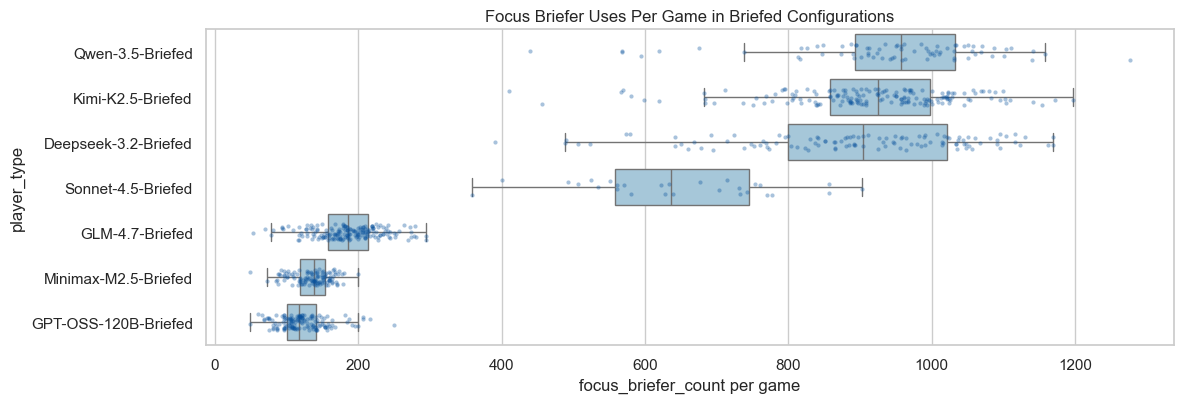

In [84]:
briefed_focus_df = telemetry_df[telemetry_df['player_type'].str.endswith('Briefed', na=False)].copy()

briefed_focus_per_game = (
    briefed_focus_df.groupby(['game_id', 'player_type'], as_index=False)
    .agg(focus_briefer_count=('focus_briefer_count', 'sum'))
)

focus_summary = (
    briefed_focus_per_game.groupby('player_type', as_index=False)
    .agg(
        games=('game_id', 'nunique'),
        mean_focus_briefer_count=('focus_briefer_count', 'mean'),
        median_focus_briefer_count=('focus_briefer_count', 'median'),
    )
    .sort_values('mean_focus_briefer_count', ascending=False)
)

display(focus_summary)

if briefed_focus_per_game.empty:
    print('No briefed telemetry rows found in model_token_usage.csv yet.')
else:
    plot_order = focus_summary['player_type'].tolist()
    fig, ax = plt.subplots(figsize=(12, max(4, 0.6 * len(plot_order))))
    sns.boxplot(
        data=briefed_focus_per_game,
        x='focus_briefer_count',
        y='player_type',
        order=plot_order,
        color='#9ecae1',
        showfliers=False,
        ax=ax,
    )
    sns.stripplot(
        data=briefed_focus_per_game,
        x='focus_briefer_count',
        y='player_type',
        order=plot_order,
        color='#08519c',
        alpha=0.35,
        size=3,
        jitter=0.18,
        ax=ax,
    )
    ax.set_title('Focus Briefer Uses Per Game in Briefed Configurations')
    ax.set_xlabel('focus_briefer_count per game')
    ax.set_ylabel('player_type')
    plt.tight_layout()
    plt.show()
